**Phase 1: Data Collection & DEG Analysis**



In [ ]:
# Step 1: Load DESeq2 results and filter significant DEGs

import pandas as pd

# Replace 'your_deseq2_results.csv' with your file name
deseq_df = pd.read_csv('/content/DESeq2_TNBC_vs_Other_full_results.csv')

# View the first few rows
deseq_df.head()

# Filter DEGs: adjusted p-value < 0.05 and |log2FoldChange| > 1
significant_degs = deseq_df[(deseq_df['padj'] < 0.05) & (abs(deseq_df['log2FoldChange']) > 1)]

# reset index
significant_degs = significant_degs.reset_index(drop=True)

# Check how many significant DEGs
print(f"Number of significant DEGs: {len(significant_degs)}")

# View top DEGs
significant_degs.head()


Number of significant DEGs: 887


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,Ensembl_ID
0,41114.234307,-7.298424,0.272787,-27.833838,1.690252e-170,9.390291e-168,CPB1,ENSG00000153002.12
1,181488.047522,1.859802,0.196642,9.446722,3.496089e-21,1.290070e-20,IGHG1,ENSG00000211896.7
2,139665.010708,1.673303,0.175494,9.528617,1.593923e-21,5.987689e-21,IGKC,ENSG00000211592.8
3,58.074173,-1.634348,0.428799,-4.269265,1.961181e-05,3.127881e-05,CSN2,ENSG00000135222.6
4,94534.226206,-1.641760,0.138994,-11.814712,3.276697e-32,1.902844e-31,IGFBP5,ENSG00000115461.5


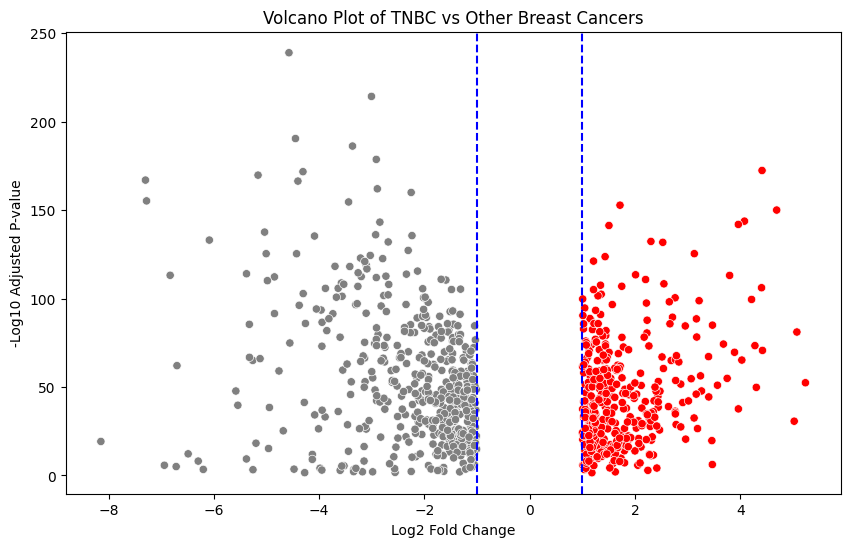

In [ ]:
# Step 2: Visualize top DEGs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Make sure to import numpy

# Volcano plot of all significant DEGs
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=significant_degs['log2FoldChange'],
    y=-np.log10(significant_degs['padj']),
    hue=(significant_degs['log2FoldChange'] > 1) & (significant_degs['padj'] < 0.05),
    palette={True: 'red', False: 'grey'},
    legend=False
)
plt.title('Volcano Plot of TNBC vs Other Breast Cancers')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.axvline(x=1, color='blue', linestyle='--')
plt.axvline(x=-1, color='blue', linestyle='--')
plt.show()


In [ ]:
import numpy as np  # needed for log10

# Step 3a: Select top DEGs
# Sort by log2 fold change descending
top_up = significant_degs[significant_degs['log2FoldChange'] > 0].sort_values(by='log2FoldChange', ascending=False).head(20)
top_down = significant_degs[significant_degs['log2FoldChange'] < 0].sort_values(by='log2FoldChange').head(20)

# Combine top up and downregulated genes
top_genes = pd.concat([top_up, top_down]).reset_index(drop=True)

# Step 3b: Add AI/ML features
top_genes['abs_log2FC'] = top_genes['log2FoldChange'].abs()
top_genes['upregulated'] = (top_genes['log2FoldChange'] > 0).astype(int)
top_genes['neg_log10_padj'] = -np.log10(top_genes['padj'])

# Save for Step 4
top_genes.to_csv('top_DEGs_TNBC_Vs_othersubtypes_AIML.csv', index=False)
print("Top DEGs saved for drug discovery/ML analysis.")

# View top_genes
top_genes.head()


Top DEGs saved for drug discovery/ML analysis.


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,Ensembl_ID,abs_log2FC,upregulated,neg_log10_padj
0,26.262862,5.238029,0.355622,15.509090,3.011170e-54,3.726695e-53,PRR27,ENSG00000187533.14,5.238029,1,52.428676
1,57.164596,5.075817,0.200224,19.341899,2.385270e-83,7.694419e-82,KRT79,ENSG00000185640.6,5.075817,1,81.113824
2,73.412064,5.024717,0.202495,11.807058,3.588998e-32,2.074565e-31,DMBT1,ENSG00000187908.20,5.024717,1,30.683073
3,210.663795,4.691864,0.142150,26.374883,2.660883e-153,8.315258e-151,MPZ,ENSG00000158887.19,4.691864,1,150.080124
4,454.006452,4.421874,0.136524,18.046671,8.379130e-73,1.930675e-71,ACAN,ENSG00000157766.19,4.421874,1,70.714291


**Phase 2: Drug-Gene Mapping & Actionability Integration**

In [ ]:
#Step 4a: Load the DGIdb TSV

import pandas as pd

# Load DGIdb interactions (latest Dec 2024)
dgidb_interactions = pd.read_csv('/content/interactions.tsv', sep='\t')

# Inspect the columns and first rows
print(dgidb_interactions.columns)
dgidb_interactions.head()


Index(['gene_claim_name', 'gene_concept_id', 'gene_name',
       'interaction_source_db_name', 'interaction_source_db_version',
       'interaction_type', 'interaction_score', 'drug_claim_name',
       'drug_concept_id', 'drug_name', 'approved', 'immunotherapy',
       'anti_neoplastic'],
      dtype='object')


,gene_claim_name,gene_concept_id,gene_name,interaction_source_db_name,interaction_source_db_version,interaction_type,interaction_score,drug_claim_name,drug_concept_id,drug_name,approved,immunotherapy,anti_neoplastic
0,CYP2D6,hgnc:2625,CYP2D6,DTC,9/2/20,NaN,0.017709,RACLOPRIDE,ncit:C152139,RACLOPRIDE,False,False,False
1,PPARG,hgnc:9236,PPARG,DTC,9/2/20,NaN,0.840123,KALOPANAX-SAPONIN F,chembl:CHEMBL1833984,CHEMBL:CHEMBL1833984,False,False,False
2,ATAD5,hgnc:25752,ATAD5,DTC,9/2/20,NaN,0.177992,RO-5-3335,chembl:CHEMBL91609,CHEMBL:CHEMBL91609,False,False,False
3,RGS4,hgnc:10000,RGS4,DTC,9/2/20,NaN,0.034319,"3,4-DICHLOROISOCOUMARIN",drugbank:DB04459,"3,4-DICHLOROISOCOUMARIN",False,False,False
4,MAPK1,hgnc:6871,MAPK1,DTC,9/2/20,NaN,0.050007,WITHAFERIN A,iuphar.ligand:13097,WITHAFERIN A,False,False,False


In [ ]:
#Step 4b: Select relevant columns

# Select only the necessary columns for merging
# Usually 'gene_name' and 'drug_name' are enough
dgidb_selected = dgidb_interactions[['gene_name', 'drug_name']]

# Check the first few rows
dgidb_selected.head()


,gene_name,drug_name
0,CYP2D6,RACLOPRIDE
1,PPARG,CHEMBL:CHEMBL1833984
2,ATAD5,CHEMBL:CHEMBL91609
3,RGS4,"3,4-DICHLOROISOCOUMARIN"
4,MAPK1,WITHAFERIN A


In [ ]:

#Step 4c: Merge with top DEGs (keep all drug interactions)

# Merge your top DEGs with DGIdb interactions
deg_drug_mapping = pd.merge(
    top_genes,
    dgidb_selected,
    left_on='gene_symbol',  # column from your DEGs
    right_on='gene_name',   # column from DGIdb
    how='inner'
)

# Check results
print(f"Number of top DEGs with known drugs: {deg_drug_mapping['gene_symbol'].nunique()}")
deg_drug_mapping.head()


Number of top DEGs with known drugs: 20


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,Ensembl_ID,abs_log2FC,upregulated,neg_log10_padj,gene_name,drug_name
0,73.412064,5.024717,0.202495,11.807058,3.588998e-32,2.074565e-31,DMBT1,ENSG00000187908.20,5.024717,1,30.683073,DMBT1,FLAGELLIN
1,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,OCRIPLASMIN
2,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,RS-25344
3,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,"6-HYDROXY-5,7-DIMETHOXYFLAVONE"
4,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,ROLIPRAM


In [ ]:
# Step 4d: Save the mapped DEGs with drugs

deg_drug_mapping.to_csv('top_DEGs_TNBC_vs_otherBreastCancers_DGIdb.csv', index=False)
print("Top DEGs mapped to known drugs and saved.")


Top DEGs mapped to known drugs and saved.


**Phase 2: Feature Engineering & *Data* Preparation** (Data Cleaning and Integration)

In [ ]:
# Keep only rows where both gene_symbol and drug_name are present
deg_drug_mapping_known = deg_drug_mapping.dropna(subset=['gene_symbol', 'drug_name'])

# Preview first 10 rows
deg_drug_mapping_known.head(10)

# Save to CSV
deg_drug_mapping_known.to_csv('top_DEGs_TNBC_tumor_vs_otherSubtypes_with_known_drugs.csv', index=False)
print("Step 7 completed: CSV contains only DEGs with known genes and drugs.")


Step 7 completed: CSV contains only DEGs with known genes and drugs.


In [ ]:

# Preview first 10 rows
deg_drug_mapping_known.head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol,Ensembl_ID,abs_log2FC,upregulated,neg_log10_padj,gene_name,drug_name
0,73.412064,5.024717,0.202495,11.807058,3.588998e-32,2.074565e-31,DMBT1,ENSG00000187908.20,5.024717,1,30.683073,DMBT1,FLAGELLIN
1,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,OCRIPLASMIN
2,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,RS-25344
3,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,"6-HYDROXY-5,7-DIMETHOXYFLAVONE"
4,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,ROLIPRAM
5,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,APREMILAST
6,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,RO20-1724
7,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,CDP840
8,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,IBUDILAST
9,358.016619,4.413950,0.148229,28.293323,4.175521e-176,3.479600e-173,COL11A2,ENSG00000204248.11,4.413950,1,172.458471,COL11A2,MK-0359


**Phase 3: Supervised Machine Learning - Gene-Level Machine Learning (Target Prioritization)

Goal: Identify which genes (DEGs) are most important or "druggable" for TNBC

Type of ML: Supervised

Task: Classification of genes into high-priority vs low-priority for TNBC drug discovery using a Random Forest classifier

Input (Features per gene):

mean_log2FC — average log2 fold change across drugs

abs_log2FC — average absolute log2 fold change

mean_neg_log10_padj — average significance of DEGs

upregulated — whether any drug is upregulated (1 = yes, 0 = no)

num_drugs — number of drugs targeting the gene

max_priority_score — maximum priority score among associated drugs

Target (Label):

high_priority — binary label indicating if a gene is “high-priority”
(e.g., top 30% of max_priority_score)

Output:

priority_prob — predicted probability that a gene is high-priority

Ranked list of genes based on priority_prob for TNBC drug discovery

Optionally, the associated drugs for the top-ranked genes


In [ ]:
# ----------------------------
# Step 1: Aggregate DEG-drug table by gene
# ----------------------------


import pandas as pd
import numpy as np
#create composite priority score
deg_drug_mapping_known['priority_score'] = (
    deg_drug_mapping_known['abs_log2FC'] * (-np.log10(deg_drug_mapping_known['padj']))
)

# Use your cleaned DEG-drug table
# deg_drug_mapping_known: columns include gene_symbol, log2FoldChange, padj, abs_log2FC, upregulated, priority_score, drug_name

# Aggregate features per gene
gene_features = deg_drug_mapping_known.groupby('gene_symbol').agg(
    mean_log2FC = ('log2FoldChange', 'mean'),
    abs_log2FC = ('abs_log2FC', 'mean'),
    mean_neg_log10_padj = ('padj', lambda x: -np.log10(x).mean()),  # significance
    upregulated = ('upregulated', 'max'),  # if any upregulated, mark as 1
    num_drugs = ('drug_name', 'nunique'),  # number of drugs targeting the gene
    max_priority_score = ('priority_score', 'max')  # max priority score among drugs
).reset_index()

# Inspect top rows
print("Aggregated gene-level features:")
display(gene_features.head(20))


Aggregated gene-level features:


/tmp/ipython-input-1920480624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deg_drug_mapping_known['priority_score'] = (


,gene_symbol,mean_log2FC,abs_log2FC,mean_neg_log10_padj,upregulated,num_drugs,max_priority_score
0,ART3,4.215064,4.215064,99.535091,1,2,419.546771
1,COL11A2,4.413950,4.413950,172.458471,1,10,761.223020
2,COL9A3,4.080145,4.080145,143.814543,1,5,586.784155
3,CPB1,-7.298424,7.298424,167.027321,0,4,1219.036265
4,CYP2A6,-5.325259,5.325259,85.455448,0,22,455.072421
5,DMBT1,5.024717,5.024717,30.683073,1,1,154.173756
6,DSG1,4.278747,4.278747,73.414023,1,4,314.120040
7,EN1,3.963807,3.963807,141.958843,1,32,562.697513
8,FABP7,3.751410,3.751410,54.902005,1,2,205.959925
9,GABRP,3.680415,3.680415,74.290497,1,78,273.419876


In [ ]:
# Number of unique genes after aggregation
num_genes = gene_features.shape[0]
print(f"Number of genes in the aggregated list: {num_genes}")


Number of genes in the aggregated list: 18


In [ ]:
# ----------------------------
# Step 2: Define high-priority label
# ----------------------------

# Determine threshold for top 30% max_priority_score
threshold = gene_features['max_priority_score'].quantile(0.7)

# Create binary target
gene_features['high_priority'] = (gene_features['max_priority_score'] >= threshold).astype(int)

# Inspect
print(f"Threshold for high-priority genes: {threshold:.2f}")
print("Gene features with high_priority label:")
display(gene_features.head(20))


Threshold for high-priority genes: 551.94
Gene features with high_priority label:


,gene_symbol,mean_log2FC,abs_log2FC,mean_neg_log10_padj,upregulated,num_drugs,max_priority_score,high_priority
0,ART3,4.215064,4.215064,99.535091,1,2,419.546771,0
1,COL11A2,4.413950,4.413950,172.458471,1,10,761.223020,1
2,COL9A3,4.080145,4.080145,143.814543,1,5,586.784155,1
3,CPB1,-7.298424,7.298424,167.027321,0,4,1219.036265,1
4,CYP2A6,-5.325259,5.325259,85.455448,0,22,455.072421,0
5,DMBT1,5.024717,5.024717,30.683073,1,1,154.173756,0
6,DSG1,4.278747,4.278747,73.414023,1,4,314.120040,0
7,EN1,3.963807,3.963807,141.958843,1,32,562.697513,1
8,FABP7,3.751410,3.751410,54.902005,1,2,205.959925,0
9,GABRP,3.680415,3.680415,74.290497,1,78,273.419876,0


In [ ]:
# ----------------------------
# Step 3: Prepare features for ML
# ----------------------------
from sklearn.preprocessing import StandardScaler

# Select features for ML
features = ['mean_log2FC', 'abs_log2FC', 'mean_neg_log10_padj', 'upregulated', 'num_drugs', 'max_priority_score']

# Create feature matrix
X = gene_features[features].copy()

# Scale numeric features (keep 'upregulated' as is since it's binary)
scaler = StandardScaler()
numeric_cols = ['mean_log2FC', 'abs_log2FC', 'mean_neg_log10_padj', 'num_drugs', 'max_priority_score']
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Inspect prepared features
X.head()


,mean_log2FC,abs_log2FC,mean_neg_log10_padj,upregulated,num_drugs,max_priority_score
0,0.816110,-0.571625,0.198325,1,-0.503650,-0.061917
1,0.856284,-0.387916,1.760242,1,-0.058708,1.159315
2,0.788856,-0.696248,1.146729,1,-0.336797,0.535829
3,-1.509577,2.276444,1.643914,0,-0.392415,2.795649
4,-1.111004,0.453851,-0.103242,0,0.608706,0.065060


In [ ]:
# ----------------------------
# Step 3b: Prepare features for ML
# ----------------------------

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 3a. Define feature columns
feature_cols = ['mean_log2FC', 'abs_log2FC', 'mean_neg_log10_padj',
                'upregulated', 'num_drugs', 'max_priority_score']

# 3b. Create feature matrix
X = gene_features[feature_cols].copy()

# 3c. Scale numeric features (leave binary 'upregulated' as-is)
numeric_cols = ['mean_log2FC', 'abs_log2FC', 'mean_neg_log10_padj',
                'num_drugs', 'max_priority_score']

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 3d. Define target label
y = gene_features['high_priority']

# 3e. Inspect prepared features and labels
print(X.head())
print(y.value_counts())


   mean_log2FC  abs_log2FC  mean_neg_log10_padj  upregulated  num_drugs  \
0     0.816110   -0.571625             0.198325            1  -0.503650   
1     0.856284   -0.387916             1.760242            1  -0.058708   
2     0.788856   -0.696248             1.146729            1  -0.336797   
3    -1.509577    2.276444             1.643914            0  -0.392415   
4    -1.111004    0.453851            -0.103242            0   0.608706   

   max_priority_score  
0           -0.061917  
1            1.159315  
2            0.535829  
3            2.795649  
4            0.065060  
high_priority
0    12
1     6
Name: count, dtype: int64


In [ ]:
# ----------------------------
# Step 4: Train Random Forest Classifier
# ----------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 4a. Split data into training and testing sets
# - 80% of genes used for training, 20% for testing
# - stratify=y ensures the proportion of high- vs low-priority genes is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4b. Initialize Random Forest classifier
# - n_estimators=500: number of trees in the forest
# - max_depth=None: trees can grow fully (good for small/medium datasets)
# - random_state=42: ensures reproducibility
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

# 4c. Train the model on the training set
rf_model.fit(X_train, y_train)

# 4d. Evaluate model performance on the test set
# - confusion_matrix shows counts of true/false positives/negatives
# - classification_report shows precision, recall, and F1-score
y_pred = rf_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[3 0]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [ ]:
# ----------------------------
# Step 5: Predict priority probabilities
# ----------------------------

# 5a. Predict probability of being high-priority for the test set (optional)
# Random Forest's predict_proba method returns probabilities for each class (0 = low, 1 = high)
y_prob_test = rf_model.predict_proba(X_test)[:, 1]  # probability of class 1 (high-priority)

# 5b. Add probability predictions for all genes
# We can predict for the entire dataset, not just the test set
gene_features['priority_prob'] = rf_model.predict_proba(X)[:, 1]

# 5c. Inspect top genes by predicted probability
top_genes = gene_features.sort_values('priority_prob', ascending=False)
print(top_genes[['gene_symbol', 'priority_prob']].head(10))


   gene_symbol  priority_prob
1      COL11A2          0.950
7          EN1          0.944
15    SERPINA6          0.926
2       COL9A3          0.902
3         CPB1          0.850
16     SLC30A8          0.784
14      S100A2          0.124
10       GPR12          0.096
0         ART3          0.076
4       CYP2A6          0.066


In [ ]:
# ----------------------------
# Step 6: Rank genes and attach associated drugs
# ----------------------------

# 6a. Copy gene_features (already has priority_prob from Step 5)
ranked_genes = gene_features.copy()

# 6b. Attach all associated drugs from the DEG–drug table
drug_mapping = deg_drug_mapping_known.groupby('gene_symbol')['drug_name'].apply(list).reset_index()
ranked_genes = ranked_genes.merge(drug_mapping, on='gene_symbol', how='left')

# 6c. Calculate number of drugs per gene (once, for consistency)
ranked_genes['num_drugs'] = ranked_genes['drug_name'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 6d. Inspect the top 10 ranked genes
print(ranked_genes[['gene_symbol', 'priority_prob', 'num_drugs', 'drug_name']].head(10))

# 6e. Save full gene-drug table to CSV
# Convert the drug list to a string so it saves fully in CSV
ranked_genes['drug_name'] = ranked_genes['drug_name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

ranked_genes.to_csv('ranked_genes_with_drugs.csv', index=False)

print("✅ Full ranked gene list with associated drugs saved to 'ranked_genes_with_drugs.csv'")

  gene_symbol  priority_prob  num_drugs  \
0        ART3          0.076          2   
1     COL11A2          0.950         10   
2      COL9A3          0.902          5   
3        CPB1          0.850          4   
4      CYP2A6          0.066         22   
5       DMBT1          0.024          1   
6        DSG1          0.062          4   
7         EN1          0.944         33   
8       FABP7          0.008          2   
9       GABRP          0.060        119   

                                           drug_name  
0                                 [TBPS, PICROTOXIN]  
1  [OCRIPLASMIN, RS-25344, 6-HYDROXY-5,7-DIMETHOX...  
2  [CYCLIC GMP, MILRINONE, CILOSTAZOL, INAMRINONE...  
3  [FADROZOLE, METYRAPONE, OSILODROSTAT, BAXDROSTAT]  
4  [COTININE, FLUOROURACIL, CYCLOPHOSPHAMIDE ANHY...  
5                                        [FLAGELLIN]  
6  [PD-98059, DDR1/2 INHIBITOR 5N, COMPOUND 66 [P...  
7  [LAPATINIB, MUBRITINIB, PIROTINIB, PYROTINIB, ...  
8                              

/tmp/ipython-input-783378096.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


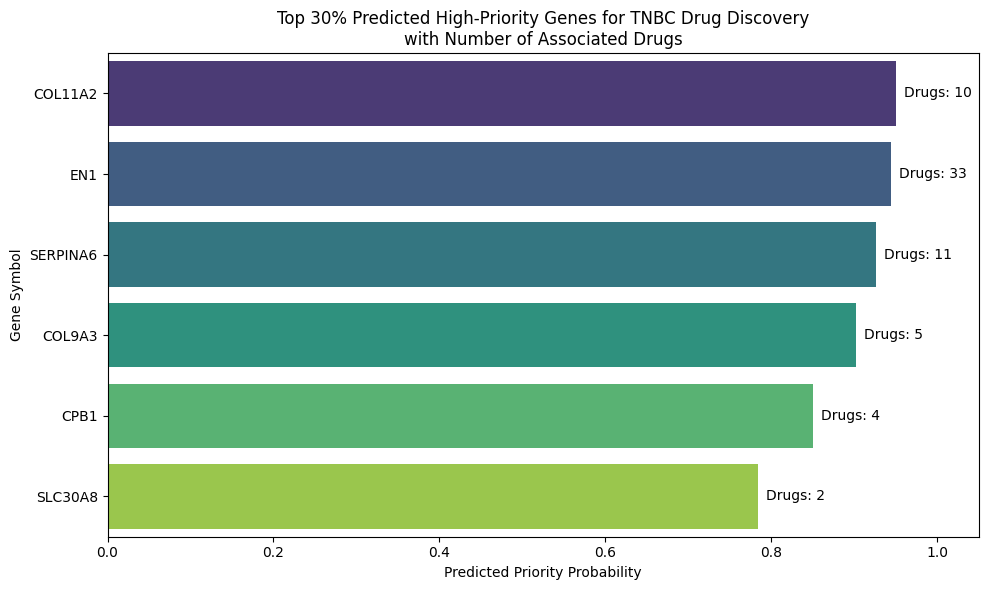

In [ ]:
# ----------------------------
# Step 7: Visualize top 30% predicted high-priority genes with number of associated drugs
# ----------------------------

# 8a. Filter top 30% genes based on predicted priority probability
cutoff = ranked_genes['priority_prob'].quantile(0.7)  # top 30%
top_genes_30pct = ranked_genes[ranked_genes['priority_prob'] >= cutoff].copy()

# 8b. Ensure num_drugs is correct
top_genes_30pct['num_drugs'] = top_genes_30pct['drug_name'].apply(lambda x: len(x.split(', ')) if isinstance(x, str) else 0)

# 8c. Sort descending so highest probability is at the top
top_genes_30pct_sorted = top_genes_30pct.sort_values('priority_prob', ascending=False).reset_index(drop=True)

# 8d. Plot horizontal bar plot
plt.figure(figsize=(10, max(6, 0.3*len(top_genes_30pct_sorted))))  # height adapts to number of genes
ax = sns.barplot(
    x='priority_prob',
    y='gene_symbol',
    data=top_genes_30pct_sorted,
    palette='viridis'
)

# 8e. Add annotations: number of drugs next to each bar
for bar, num_drugs in zip(ax.patches, top_genes_30pct_sorted['num_drugs']):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax.text(
        width + 0.01,  # slightly to the right of the bar
        y_pos,
        f"Drugs: {num_drugs}",
        va='center',
        fontsize=10
    )

plt.xlabel("Predicted Priority Probability")
plt.ylabel("Gene Symbol")
plt.title("Top 30% Predicted High-Priority Genes for TNBC Drug Discovery\nwith Number of Associated Drugs")
plt.xlim(0, 1.05)  # leave space for annotations
plt.tight_layout()
plt.show()


Phase 4: Supervised Machine Learning - Drug-Level Machine Learning (Target Prioritization)

In [ ]:
# ----------------------------
# Step 1: Aggregate DEG–drug table by DRUG
# ----------------------------
import pandas as pd
import numpy as np

# Ensure priority_score exists
deg_drug_mapping_known['priority_score'] = (
    deg_drug_mapping_known['abs_log2FC'] * (-np.log10(deg_drug_mapping_known['padj']))
)

# Aggregate per drug (one row per drug)
drug_features = deg_drug_mapping_known.groupby('drug_name').agg(
    mean_log2FC=('log2FoldChange', 'mean'),
    abs_log2FC=('abs_log2FC', 'mean'),
    mean_neg_log10_padj=('padj', lambda x: -np.log10(x).mean()),
    num_targets=('gene_symbol', 'nunique'),
    num_upregulated_targets=('upregulated', 'sum'),
    max_priority_score=('priority_score', 'max')
).reset_index()

print("Aggregated drug-level features:")
display(drug_features.head(20))
print(f"Number of unique drugs in aggregated list: {drug_features.shape[0]}")


Aggregated drug-level features:


/tmp/ipython-input-3646489593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deg_drug_mapping_known['priority_score'] = (


,drug_name,mean_log2FC,abs_log2FC,mean_neg_log10_padj,num_targets,num_upregulated_targets,max_priority_score
0,3-FORMYLINDOLE,-5.325259,5.325259,85.455448,1,0,455.072421
1,"6-HYDROXY-5,7-DIMETHOXYFLAVONE",4.413950,4.413950,172.458471,1,1,761.223020
2,ABP-700,3.680415,3.680415,74.290497,1,1,273.419876
3,ACALABRUTINIB,3.963807,3.963807,141.958843,1,1,562.697513
4,ACAMPROSATE CALCIUM,3.680415,3.680415,74.290497,1,1,273.419876
5,ACETAMINOPHEN,-5.325259,5.325259,85.455448,1,0,455.072421
6,ADINAZOLAM,3.680415,3.680415,74.290497,1,2,273.419876
7,ADIPIPLON,3.680415,3.680415,74.290497,1,2,273.419876
8,AEE788,3.963807,3.963807,141.958843,1,1,562.697513
9,AFATINIB,3.963807,3.963807,141.958843,1,1,562.697513


Number of unique drugs in aggregated list: 196


In [ ]:
# ----------------------------
# Step 2: Define high-priority label (top 30% of drugs)
# ----------------------------
threshold = drug_features['max_priority_score'].quantile(0.7)
drug_features['high_priority'] = (drug_features['max_priority_score'] >= threshold).astype(int)

print(f"Threshold for high-priority drugs: {threshold:.2f}")
display(drug_features.head(10))


Threshold for high-priority drugs: 562.70


,drug_name,mean_log2FC,abs_log2FC,mean_neg_log10_padj,num_targets,num_upregulated_targets,max_priority_score,high_priority
0,3-FORMYLINDOLE,-5.325259,5.325259,85.455448,1,0,455.072421,0
1,"6-HYDROXY-5,7-DIMETHOXYFLAVONE",4.413950,4.413950,172.458471,1,1,761.223020,1
2,ABP-700,3.680415,3.680415,74.290497,1,1,273.419876,0
3,ACALABRUTINIB,3.963807,3.963807,141.958843,1,1,562.697513,1
4,ACAMPROSATE CALCIUM,3.680415,3.680415,74.290497,1,1,273.419876,0
5,ACETAMINOPHEN,-5.325259,5.325259,85.455448,1,0,455.072421,0
6,ADINAZOLAM,3.680415,3.680415,74.290497,1,2,273.419876,0
7,ADIPIPLON,3.680415,3.680415,74.290497,1,2,273.419876,0
8,AEE788,3.963807,3.963807,141.958843,1,1,562.697513,1
9,AFATINIB,3.963807,3.963807,141.958843,1,1,562.697513,1


In [ ]:
# ----------------------------
# Step 3: Prepare features for ML
# ----------------------------
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'mean_log2FC', 'abs_log2FC', 'mean_neg_log10_padj',
    'num_targets', 'num_upregulated_targets', 'max_priority_score'
]

X = drug_features[feature_cols].copy()

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = drug_features['high_priority']

print("Feature matrix and labels ready:")
print(pd.DataFrame(X_scaled, columns=feature_cols).head())
print(y.value_counts())


Feature matrix and labels ready:
   mean_log2FC  abs_log2FC  mean_neg_log10_padj  num_targets  \
0    -1.729908    1.166216            -0.248000    -0.124676   
1     0.685151    0.137891             2.042178    -0.124676   
2     0.503254   -0.689832            -0.541894    -0.124676   
3     0.573528   -0.370051             1.239337    -0.124676   
4     0.503254   -0.689832            -0.541894    -0.124676   

   num_upregulated_targets  max_priority_score  
0                -1.261542            0.194002  
1                -0.019018            1.626129  
2                -0.019018           -0.655741  
3                -0.019018            0.697456  
4                -0.019018           -0.655741  
high_priority
0    135
1     61
Name: count, dtype: int64


In [ ]:
# ----------------------------
# Step 4: Train Random Forest Classifier
# ----------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

rf_model_drug = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42
)
rf_model_drug.fit(X_train, y_train)

y_pred = rf_model_drug.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[28  0]
 [ 0 12]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        12

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [ ]:
# ----------------------------
# Step 5: Predict probability of being high-priority (for all drugs)
# ----------------------------
drug_features['priority_prob'] = rf_model_drug.predict_proba(X_scaled)[:, 1]

top_drugs = drug_features.sort_values('priority_prob', ascending=False)
print("Top 10 predicted high-priority drugs:")
display(top_drugs[['drug_name', 'priority_prob', 'num_targets', 'num_upregulated_targets', 'max_priority_score']].head(10))


Top 10 predicted high-priority drugs:


,drug_name,priority_prob,num_targets,num_upregulated_targets,max_priority_score
1,"6-HYDROXY-5,7-DIMETHOXYFLAVONE",1.0,1,1,761.223020
3,ACALABRUTINIB,1.0,1,1,562.697513
10,ALCLOMETASONE,1.0,1,0,809.926056
11,ALLITINIB,1.0,1,1,562.697513
58,COLLAGENASE CLOSTRIDIUM HISTOLYTICUM-AAES,1.0,1,1,761.223020
63,CP-724714,1.0,1,1,562.697513
9,AFATINIB,1.0,1,1,562.697513
8,AEE788,1.0,1,1,562.697513
28,BECLOMETHASONE,1.0,1,0,809.926056
29,BI-4142,1.0,1,1,562.697513


/tmp/ipython-input-1642030240.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


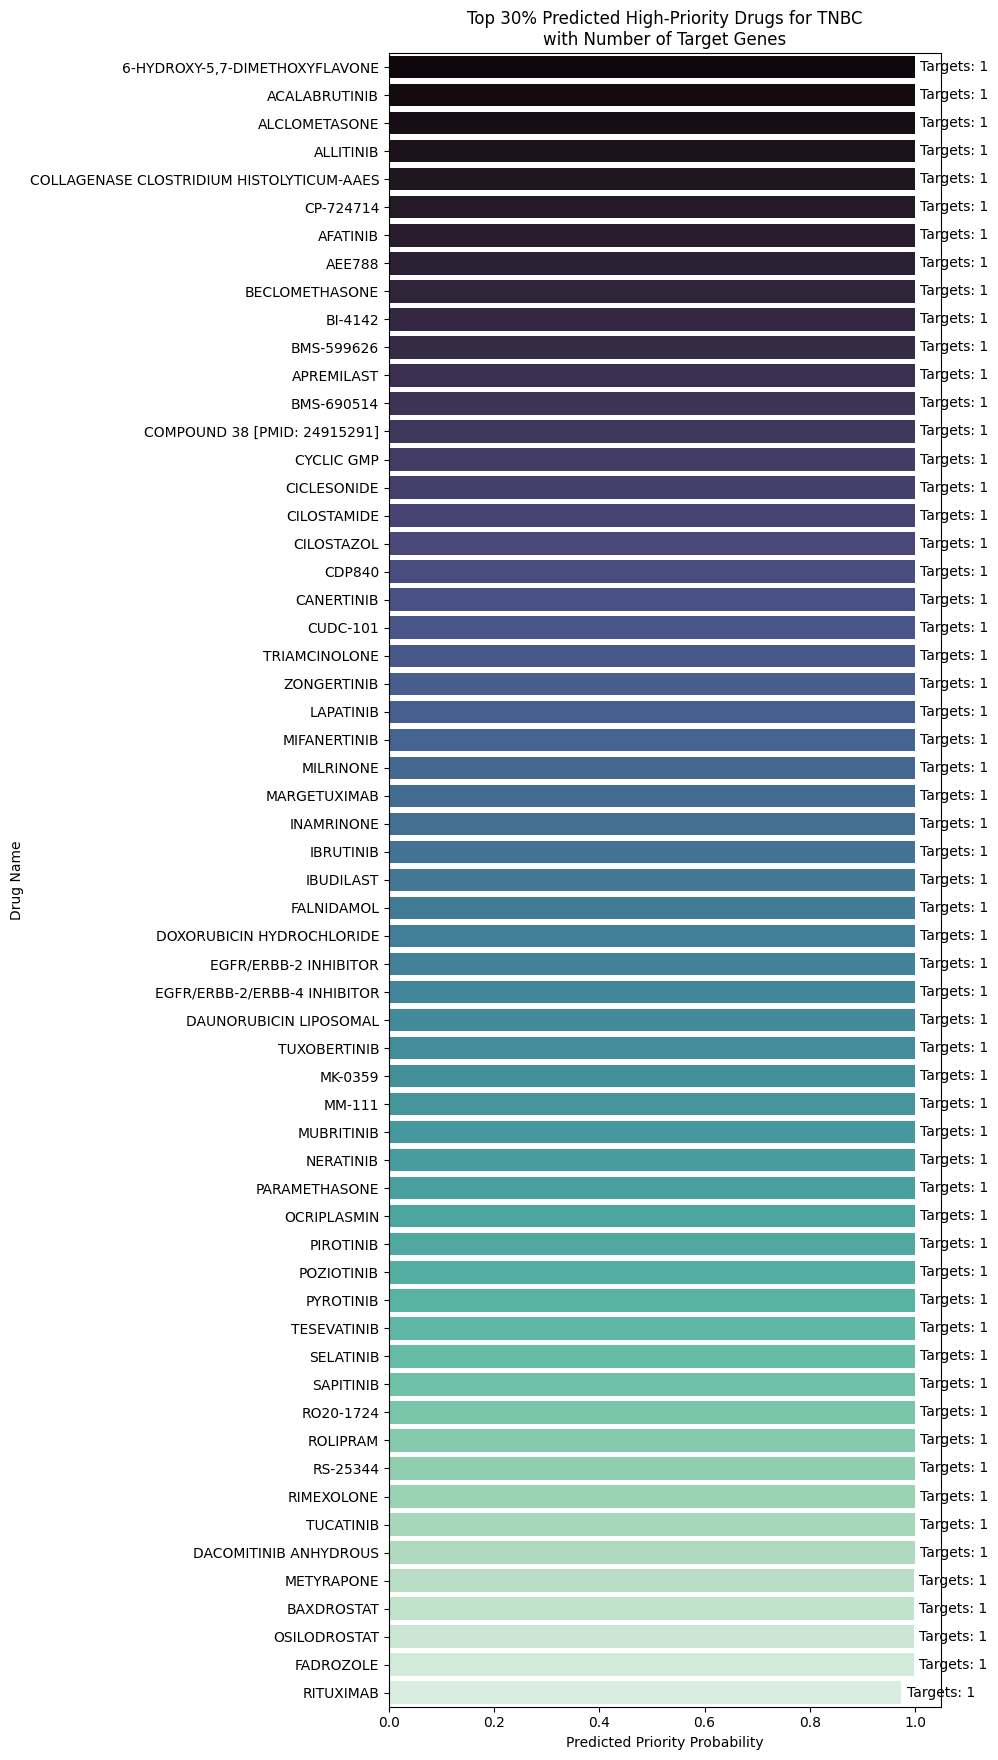

In [ ]:
# ----------------------------
# Step 6: Visualize top 30% high-priority drugs
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

cutoff = top_drugs['priority_prob'].quantile(0.7)
top_drugs_30pct = top_drugs[top_drugs['priority_prob'] >= cutoff].copy()
top_drugs_30pct_sorted = top_drugs_30pct.sort_values('priority_prob', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, max(6, 0.3*len(top_drugs_30pct_sorted))))
ax = sns.barplot(
    x='priority_prob',
    y='drug_name',
    data=top_drugs_30pct_sorted,
    palette='mako'
)

for bar, num_targets in zip(ax.patches, top_drugs_30pct_sorted['num_targets']):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    ax.text(
        width + 0.01,
        y_pos,
        f"Targets: {num_targets}",
        va='center',
        fontsize=10
    )

plt.xlabel("Predicted Priority Probability")
plt.ylabel("Drug Name")
plt.title("Top 30% Predicted High-Priority Drugs for TNBC\nwith Number of Target Genes")
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()


Feature importances:


,Feature,Importance
2,mean_neg_log10_padj,0.392638
5,max_priority_score,0.392595
0,mean_log2FC,0.112147
1,abs_log2FC,0.094499
4,num_upregulated_targets,0.008013
3,num_targets,0.000108


/tmp/ipython-input-3891616892.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='crest')


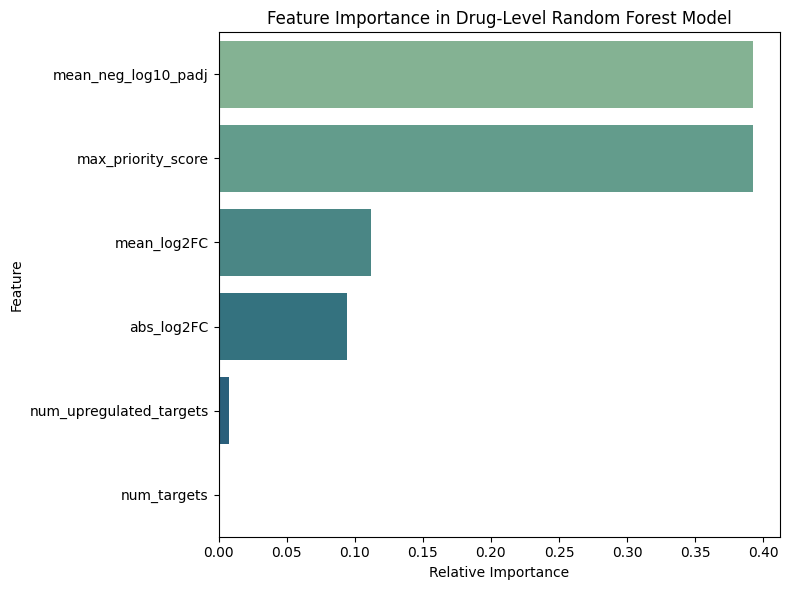

In [ ]:
# ----------------------------
# Step 8: Feature Importance (optional but consistent with gene-level)
# ----------------------------
importances = rf_model_drug.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature importances:")
display(feature_importance_df)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='crest')
plt.title('Feature Importance in Drug-Level Random Forest Model')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
